# Deep Neural Network for Image Classification: Application

You will build a deep network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning. 

Let's get started!

## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Dataset

**Problem Statement**: You are given a dataset (".csv") containing:

Let's get more familiar with the dataset. Load the data by running the cell below.

In [2]:
# Loading the data 
def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    num_points = len(lines)
    dim_points = 28 * 28
    data = np.empty((num_points, dim_points))
    labels = np.empty(num_points)
    
    for ind, line in enumerate(lines):
        num = line.split(',')
        labels[ind] = int(num[0])
        data[ind] = [ int(x) for x in num[1:] ]
        
    return (data, labels)

train_set_x_flatten, train_y = read_data("sample_train.csv")
test_set_x_flatten, test_y = read_data("sample_test.csv")
print(train_set_x_flatten.shape, test_set_x_flatten.shape)
print(train_y.shape, test_y.shape)

(6000, 784) (1000, 784)
(6000,) (1000,)


The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 4.0


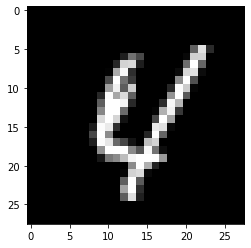

In [3]:
# Example of a picture
index = 700
img = train_set_x_flatten[index,:].reshape(28,28)
plt.imshow(img, cmap = 'gray')
print ("y = " + str(train_y[index]) )
#print(type(train_y[index]))

In [4]:
# Reshape the training and test examples 

train_set_x_flatten = train_set_x_flatten.T
#train_set_y = train_set_y.reshape(-1,1)
target = np.array(train_y).reshape(-1)
t = [int(x) for x in target]
print((t[5]))
train_set_y = np.eye(10)[t].T

print(train_set_y[:,5])

test_set_x_flatten = test_set_x_flatten.T
target = np.array(test_y).reshape(-1)
t = [int(x) for x in target]
print((t[2]))
test_set_y = np.eye(10)[t].T
print(test_set_y[:,2])

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

# Standardize data to have feature values between 0 and 1.
train_x = train_set_x_flatten/255.
test_x = test_set_x_flatten/255.


2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
train_set_x_flatten shape: (784, 6000)
train_set_y shape: (10, 6000)
test_set_x_flatten shape: (784, 1000)
test_set_y shape: (10, 1000)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

## 3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

You will a 2-layer neural network

You will then compare the performance of these models, and also try out different values for $L$. 

Let's look at the two architectures.

### 2-layer neural network

Detailed Architecture :
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.


### General methodology

As usual you will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement the model!

## 4 - Two-layer neural network

**Question**:  Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

# Linear Forward 
Now that you have initialized your parameters, you will do the forward propagation module. You will start by implementing some basic functions that you will use later when implementing the model. You will complete three functions in this order:

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 

**Exercise**: Build the linear part of forward propagation.


In [5]:
# linear_forward

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W,A) + b
        
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

# Linear-Activation Forward
In this notebook, you will use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. We have provided you with the `sigmoid` function. This function returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. We have provided you with the `relu` function. This function returns **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call:
``` python
A, activation_cache = relu(Z)
```

In [6]:
# linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

## Cost function

Now you will implement forward and backward propagation. You need to compute the cost, because you want to check if your model is actually learning.

**Exercise**: Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [7]:
# compute_cost

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = -1/(m*Y.shape[0]) * np.sum((Y * np.log(AL)) + ((1-Y) * np.log(1 - AL)))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

## Backward propagation module

Just like with forward propagation, you will implement helper functions for backpropagation. Remember that back propagation is used to calculate the gradient of the loss function with respect to the parameters. 


<!-- 
For those of you who are expert in calculus (you don't need to be to do this assignment), the chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, you use the previous chain rule and you do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During the backpropagation, at each step you multiply your current gradient by the gradient corresponding to the specific layer to get the gradient you wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, you use the previous chain rule and you do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

This is why we talk about **backpropagation**.
!-->

Now, similar to forward propagation, you are going to build the backward propagation in three steps:
- LINEAR backward
- LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model

### Linear backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.Here are the formulas you need:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


In [8]:
# linear_backward

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

### Linear-Activation backward

Next, you will create a function that merges the two helper functions: **`linear_backward`** and the backward step for the activation **`linear_activation_backward`**. 

To help you implement `linear_activation_backward`, we provided two backward functions:
- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit. You can call it as follows:

```python
dZ = sigmoid_backward(dA, activation_cache)
```

- **`relu_backward`**: Implements the backward propagation for RELU unit. You can call it as follows:

```python
dZ = relu_backward(dA, activation_cache)
```

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{11}$$.  

**Exercise**: Implement the backpropagation for the *LINEAR->ACTIVATION* layer.

In [9]:
# linear_activation_backward

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

## Initialization
Instructions:

The model's structure is: LINEAR -> RELU -> LINEAR -> SIGMOID.
Use random initialization for the weight matrices. Use np.random.randn(shape)*0.01 with the correct shape.
Use zero initialization for the biases. Use np.zeros(shape).

### Update Parameters

In this section you will update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. After computing the updated parameters, store them in the parameters dictionary. 

In [10]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 784     # num_px * num_px * 3
n_h = 180
n_y = 10
layers_dims = (n_x, n_h, n_y)

In [11]:
# two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.05, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims

    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, activation = 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = 'sigmoid')
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = 'relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        for l in range(len(parameters) // 2):
            parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - (learning_rate * grads["dW" + str(l + 1)])
            parameters["b" + str(l+1)] = parameters['b' + str(l+1)] - (learning_rate * grads['db' + str(l + 1)])

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Run the cell below to train your parameters. See if your model runs. The cost should be decreasing. It may take up to 5 minutes to run 2500 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

Cost after iteration 0: 0.6920740192062635
Cost after iteration 100: 0.2694007758416456
Cost after iteration 200: 0.15945163462106557
Cost after iteration 300: 0.11703680288532244
Cost after iteration 400: 0.09617255589183166
Cost after iteration 500: 0.08326725358720874
Cost after iteration 600: 0.07462276252881442
Cost after iteration 700: 0.06844189724158382
Cost after iteration 800: 0.06372338667734878
Cost after iteration 900: 0.059904491604666286


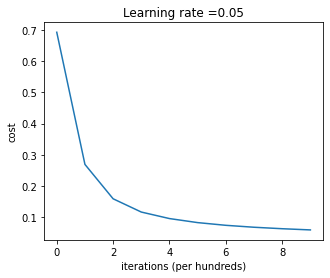

In [12]:
parameters = two_layer_model(train_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 1000, print_cost=True)

Good thing you built a vectorized implementation! Otherwise it might have taken 10 times longer to train this.

Now, you can use the trained parameters to classify images from the dataset. To see your predictions on the training and test sets, run the cell below.

In [13]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((y.shape[0],m))
    
    # Forward propagation
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    probas, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    #print(probas[:,2])
    #print(probas.shape[1])
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        temp = np.array(probas[:,i])
        t = np.where(temp == np.amax(temp))
        p[t[0],i] = 1
    #print(p.shape[0])
    #print(p.shape[1])
    #print(y.shape[0])
    #print(y.shape[1])
        #for t in range(0, probas.shape[0]):
         #   if probas[t,i] > 0.5:
          #      p[t,i] = 1
           # else:
            #    p[t,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum(p == y)/(m* y.shape[0])))
        
    return p

In [14]:
predictions_train = predict(train_x, train_set_y, parameters)

Accuracy: 0.985


**Expected Output**:
<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [15]:
predictions_test = predict(test_x, test_set_y, parameters)

Accuracy: 0.9782


**Expected Output**:

<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 0.72 </td>
    </tr>
</table>

**References**:

- for auto-reloading external module: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython